In [116]:
import seaborn as sns 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [118]:
df = pd.read_csv('../data/tester.csv')
cities_keep = ['seattle', 'kenmore', 'sammamish', 'redmond', 'federal way', 'des moines', 'maple valley', 
                'bellevue', 'auburn', 'kent', 'renton', 'kirkland']
cities_keep = ['seattle', 'sammamish', 'redmond', 
                'bellevue', 'auburn', 'kent', 'renton', 'kirkland']
cities = [f'city_{i}' for i in df.City.unique() if i in cities_keep]
df = df[['price', 'grade', 'bedrooms', 'sqft_living', 'sqft_lot15', 'sqft_basement', 'zipcode', 'waterfrontness']]
print(df.shape)
def get_clean_data(df):
    for col in ['price', 'grade', 'bedrooms', 'sqft_living', 'sqft_lot15', 'sqft_basement']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        mean = df[col].mean()
        std = df[col].std()
        df = df[(df[col] < (mean + 5*std)) & (df[col] > (mean - 5*std))]
    return df

df = get_clean_data(df)
print(df.shape)

(21597, 8)
(21198, 8)


/Users/samuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


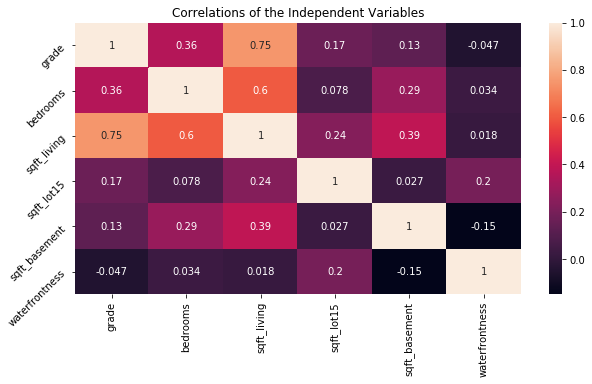

In [119]:
def get_heatmap(df):
    '''This function will create a heatmap to compare the different independent variables of our model'''
    fig, ax =plt.subplots(figsize=(10,5)) 
    sns.heatmap(df.drop(['price', 'zipcode'], axis = 1).corr(), annot = True, ax=ax)
    ax.set_title('Correlations of the Independent Variables')
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 45)
get_heatmap(df)

### Regression

In [120]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm 
import pandas as pd

In [121]:
X = df[[i for i in df.columns if i != 'price']]
#X.sqft_lot15 = X.sqft_lot15.map(lambda x: 1/x)
y = df[['price']]/1000000
y = np.log(y)
X = sm.add_constant(X)
#using zipcode to stratify the data 
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state = 0, train_size = .8, stratify = X.zipcode.values)
x_train = x_train.drop('zipcode', axis = 1) #dropping zipcode
x_test = x_test.drop('zipcode', axis = 1) #dropping zipcode 

def regression(x_train= x_train,y_train=y_train):
    '''This function will create and retrun a regression model along with the summary'''
    linear = sm.OLS(y_train,x_train, hasconst = True).fit() 
    summary = linear.summary()
    print(summary)
    
    return linear, summary 

model, summary = regression()



                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     4435.
Date:                Thu, 09 Jul 2020   Prob (F-statistic):               0.00
Time:                        09:42:04   Log-Likelihood:                -4498.7
No. Observations:               16958   AIC:                             9011.
Df Residuals:                   16951   BIC:                             9066.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.3979      0.022   -106.

In [122]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     4435.
Date:                Thu, 09 Jul 2020   Prob (F-statistic):               0.00
Time:                        09:42:04   Log-Likelihood:                -4498.7
No. Observations:               16958   AIC:                             9011.
Df Residuals:                   16951   BIC:                             9066.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.3979      0.022   -106.609      0.000      -2.442      -2.354
grade              0.1670      0.003     48.585      0.000       0.160       0.174
bedrooms          -0.0217      0.004     -6.182      0.000      -0.029      -0.015
sqft_living        0.0002   5.66e-06     41.522      0.000       0.000       0.000
sqft_lot15      6.537e-07   1.98e-07      3.307      0.001    2.66e-07    1.04e-06
sqft_basement   5.604e-05   6.57e-06      8.523      0.000    4.31e-05    6.89e-05
waterfrontness    -0.3501      0.006    -56.715      0.000      -0.362      -0.338
==============================================================================
Omnibus:                      119.469   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.228
Skew:                          -0.001   Prob(JB):                     9.89e-41
Kurtosis:                       3.511   Cond. No.                     1.57e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

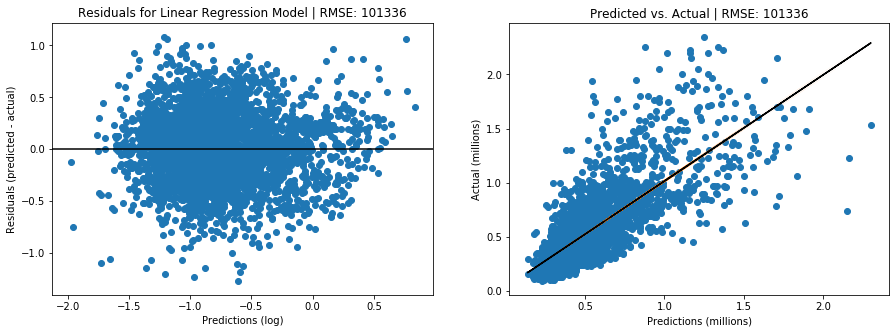

In [123]:
def scatter(model, x_test=x_test, y_test=y_test): 
    '''This function will create a scatter plot for the residuals of the model'''
    predictions = model.predict(x_test)
    residuals = predictions - y_test.values.squeeze()

    fig, ax = plt.subplots(1,2, figsize = (15,5))
    
    #residual plot
   
    ax[0].scatter(predictions, residuals)


    ax[0].axhline(y = 0, xmin = predictions.min(), xmax = 2, color = 'black')
    ax[0].set_xlabel('Predictions (log)'); ax[0].set_ylabel('Residuals (predicted - actual)'); 
    loss = mean_squared_error(y_test, predictions)*1000000
    ax[0].set_title(f'Residuals for Linear Regression Model | RMSE: {int(round(loss, 0))}')
    
    #predictions vs actual 
    predictions = np.exp(predictions)
    y_test = np.exp(y_test)
    a,b = np.polyfit(predictions, y_test, deg = 1)
    y_est = a * predictions + b
    y_err = predictions.std() * np.sqrt(1/len(predictions)
                                        +(predictions - predictions.mean())**2 / 
                                        np.sum((predictions - predictions.mean())**2))
    ax[1].scatter(predictions, y_test)
    ax[1].set_xlabel('Predictions (millions)'); ax[1].set_ylabel('Actual (millions)')
    ax[1].set_title(f'Predicted vs. Actual | RMSE: {int(round(loss, 0))}')
    ax[1].plot(predictions, y_est, '-', color = 'black')
    ax[1].fill_between(predictions, y_est-y_err, y_est + y_err)
    
scatter(model = model)